In [12]:
# This simulation studies the performance when the user draws the different 
# shapes when Z is or is not diversed.
import sys
sys.path.append('../utils')

from SimulationUtils import *
from MathUtils import *
from PlotUtils import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.spatial.transform import Rotation   



In [13]:
def eq_traj(x, y):
    n0, n1 = x.shape[0], x.shape[1]
    for i in range(n0):
        for j in range(n1):
            if np.linalg.norm(x[i][j] - y[i][j]) > 1e-4:
                print(f"test_idx = {i}, traj_sample_idxs={j}, loc1={x[i][j]}, "
                      f"loc2={y[i][j]}")
                return False
    print("Equal!")
    return True

# Spiral trajectory along Z axis
def generate_spiral_trajectories(xycenter, radius, zstart, zstop, n_samples=100):
    step = 2*math.pi / 100
    theta = np.arange(-math.pi, math.pi, step)
    x = xycenter[0] + radius * np.sin(theta)
    y = xycenter[1] + radius * np.cos(theta)
    n = x.shape[0]    
    
    x, y, z = x[:, None], y[:, None], \
        np.linspace(zstart, zstop, num=n_samples)[:, None]
    print(x.shape, y.shape, z.shape)
    return np.hstack((x, y, z))

def load_trajectories(filename):
    data = sio.loadmat(filename)
    trajectory = data["trajectories"]
    return trajectory

def sim_track(trajectories, antenna_positions, phase_mu, phase_sigma, 
              math_utils, sim_utils, n_boards=3, n_at_per_board = 2):
    n_samples = trajectories.shape[0]
    phases, phasediffs = np.zeros((n_samples, n_boards, n_at_per_board)), \
        np.zeros((n_samples, n_boards))
    # I am too lazy to use broadcasting. Change it to broadcasting style when I 
    # want it faster.
    for i in range(n_samples):
        phases[i] = math_utils.compute_phase_from_physical_positions(trajectories[i],
                                                                     antenna_positions)
        phasediffs[i] = math_utils.wrap_phase(phases[i,:, 1] - phases[i,:, 0])
    
    est_phases = sim_utils.add_init_phases(phases)
    est_phases = sim_utils.add_gaussian_noise(est_phases, phase_mu, phase_sigma)
    est_phasediffs = math_utils.wrap_phase(est_phases[:,:,1] - est_phases[:,:, 0])

    ####### Simulation step 3: tracking. ###############
    est_positions = np.zeros((n_samples, 3))
    phase_0 = est_phases[0]
    phasediff_0 =  math_utils.wrap_phase(phase_0[:,1] - phase_0[:,0])
    accum_phasediffchange_array = np.zeros((n_samples, 3))
    accum_phasediffchange = np.zeros((3, ))

    prev_phasediff = phasediff_0
    last_position = trajectories[0]
    for i in range(n_samples):
        phase_i = est_phases[i]
        # for ith sample, phasediff_i = phase difference between other antennas and antenna 0
        phasediff_i = math_utils.wrap_phase(phase_i[:,1] - phase_i[:,0]) 
        accum_phasediffchange += math_utils.wrap_phase(phasediff_i - prev_phasediff)
        accum_phasediffchange_array[i] = accum_phasediffchange

        this_range = [(last_position[0] - 0.1, last_position[0] + 0.1), 
                      (last_position[1] - 0.1, last_position[1] + 0.1), 
                      (last_position[2] - 0.1, last_position[2] + 0.1)]
        est_position = math_utils.localization_solver_multiboards(antenna_positions, 
                    trajectories[0], accum_phasediffchange, this_range, last_position)
        est_positions[i] = est_position

        # Update prev status.
        prev_phasediff = phasediff_i
        last_position = est_position
        
    return est_positions, accum_phasediffchange_array

tmp_ats - mu_at: [[-0.75 -0.4  -0.2 ]
 [ 0.75 -0.4  -0.2 ]
 [-0.75  0.4  -0.2 ]
 [ 0.75  0.4   0.6 ]]
(tmp_ats - mu_at) @ rotmat: [[-0.7297271  -0.44428108 -0.18058981]
 [ 0.74748453 -0.44428108  0.07988245]
 [-0.68221416  0.30747302 -0.45004908]
 [ 0.66445674  0.58108913  0.55075644]]
new_ats: [[ 0.0202729  -0.04428108  0.01941019]
 [ 1.49748453 -0.04428108  0.27988245]
 [ 0.06778584  0.70747302 -0.25004908]
 [ 1.41445674  0.98108913  0.75075644]]
Antenna positions for diverse_sameconvex: [[[ 0.0202729  -0.04428108  0.01941019]
  [ 1.49748453 -0.04428108  0.27988245]]

 [[ 0.0202729  -0.04428108  0.01941019]
  [ 0.06778584  0.70747302 -0.25004908]]

 [[ 0.0202729  -0.04428108  0.01941019]
  [ 1.41445674  0.98108913  0.75075644]]]
good!


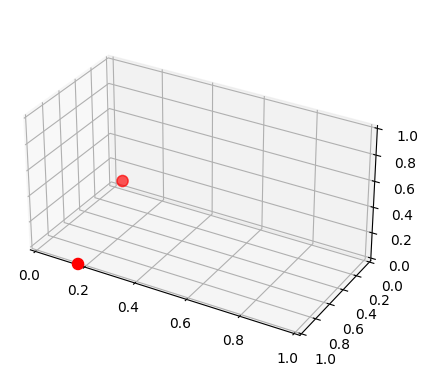

In [45]:
n_board, n_at_per_board = 3, 2
antenna_positions_pool = {
    "diverse": np.array([[[0, 0, 0], [1.5, 0.0, 0.1]],
                         [[0, 0, 0], [0, 0.8, 0.5]],
                         [[0, 0, 0], [1.5, 0.8, 0.8]]]),
    "non_diverse": np.array([[[0, 0, 0], [1.5, 0, 0]],
                         [[0, 0, 0], [0, 0.8, 0]],
                         [[0, 0, 0], [1.5, 0.8, 0.8]]]),
                         
    "Z0":  np.array([[[0, 0, 0], [1.5, 0, 0]],
                         [[0, 0, 0], [0, 0.8, 0]],
                         [[0, 0, 0], [1.5, 0.8, 0]]]),
}

tmp_ats = np.array(([[0, 0, 0], [1.5,0,0], [0, 0.8, 0], [1.5, 0.8, 0.8]]))
mu_at = np.mean(tmp_ats, axis=0)
rotmat = Rotation.from_euler("zyx", [0, 10, 20], degrees=True).as_matrix()
new_ats = (tmp_ats - mu_at) @ rotmat + mu_at
print(f"tmp_ats - mu_at: {tmp_ats - mu_at}")
print(f"(tmp_ats - mu_at) @ rotmat: {(tmp_ats - mu_at) @ rotmat}")
print(f"new_ats: {new_ats}")
tmp = np.zeros((3,2,3))
tmp[0, 0] = copy.deepcopy(new_ats[0])
tmp[1, 0] = copy.deepcopy(new_ats[0])
tmp[2, 0] = copy.deepcopy(new_ats[0])
tmp[0, 1] = copy.deepcopy(new_ats[1])
tmp[1, 1] = copy.deepcopy(new_ats[2])
tmp[2, 1] = copy.deepcopy(new_ats[3])

antenna_positions_pool["diverse_sameconvex"] = tmp
print(f"Antenna positions for diverse_sameconvex: {tmp}")

# trajectory = generate_spiral_trajectories(xycenter=np.array([0,0]), 
#                                                     radius=0.2, zstart=0, 
#                                                     zstop=0)



# Default start position. We can change it to understand the effect of different
# starting positions.
start_center = np.array([0.74, 0.17, 0]) 
phase_mu, phase_sigma = 0, np.deg2rad(4) # suppose sigma = 2 degrees

sim_utils = SimulationUtils()
math_utils = MathUtils()
plot_utils = PlotUtils()

antenna_positions = antenna_positions_pool['diverse_sameconvex']
# antenna_positions = antenna_positions_pool['non_diverse']
fig1 = plt.figure(1)
ax = fig1.add_subplot(projection='3d')
ax.scatter(antenna_positions[0, :, 0], antenna_positions[0, :, 1],  antenna_positions[0, :, 2], marker='.', s=256, c='r')
ax.scatter(antenna_positions[1, :, 0], antenna_positions[1, :, 1],  antenna_positions[1, :, 2], marker='.', s=256, c='r')
ax.scatter(antenna_positions[2, :, 0], antenna_positions[2, :, 1],  antenna_positions[2, :, 2], marker='.', s=256, c='r')
ax.invert_yaxis()
ax.set_xlim([0, 1])
ax.set_ylim([1, 0])
ax.set_zlim([0, 1])
ax.set_box_aspect([2,1,1])



In [46]:
# Traverse all possible combinations of xs, ys, zs
def sim_z_diversity(trajectory, z_diversity, xs, ys, zs):
    if z_diversity == "diverse":
        antenna_positions = antenna_positions_pool['diverse']
    elif z_diversity == "non_diverse":
        antenna_positions = antenna_positions_pool['non_diverse']
    elif z_diversity == "Z0":
        antenna_positions = antenna_positions_pool['Z0']
    else:
        antenna_positions = antenna_positions_pool["diverse_sameconvex"]


    n_samples = trajectory.shape[0]

    iT, n_test = 0, xs.shape[0] * ys.shape[0] * zs.shape[0]

    all_test_trajectories = np.zeros((n_test, n_samples, 3))
    all_errors = np.zeros((n_test, n_samples))
    all_center_positions = np.zeros((n_test, 3))

    for x in xs:
        for y in ys:
            for z in zs:
                trajectories = trajectory + np.array([x,y,z])
                est_positions, accum_phasediffchange_array = \
                    sim_track(trajectories, antenna_positions, phase_mu, phase_sigma,
                            math_utils, sim_utils)
                errors = np.linalg.norm(est_positions - trajectories, axis=1) * 1e3

                all_test_trajectories[iT] = copy.deepcopy(trajectories)
                all_errors[iT] = copy.deepcopy(errors)
                all_center_positions[iT] = np.array([x,y,z])

                iT += 1
    print(all_errors.shape)
    return all_test_trajectories, all_errors, all_center_positions

# xs, ys, zs have equal length
def sim_z_diversity_array(trajectory, z_diversity, xs, ys, zs):
    if z_diversity == "diverse":
        antenna_positions = antenna_positions_pool['diverse']
    elif z_diversity == "non_diverse":
        antenna_positions = antenna_positions_pool['non_diverse']
    elif z_diversity == "Z0":
        antenna_positions = antenna_positions_pool['Z0']
    else:
        antenna_positions = antenna_positions_pool["diverse_sameconvex"]

    n_samples = trajectory.shape[0]

    iT, n_test = 0, xs.shape[0]

    all_test_trajectories = np.zeros((n_test, n_samples, 3))
    all_errors = np.zeros((n_test, n_samples))
    all_center_positions = np.zeros((n_test, 3))

    for (x,y,z) in zip(xs, ys, zs):
        print(x,y,z)
        trajectories = trajectory + np.array([x,y,z])
        est_positions, accum_phasediffchange_array = \
            sim_track(trajectories, antenna_positions, phase_mu, phase_sigma,
                    math_utils, sim_utils)
        errors = np.linalg.norm(est_positions - trajectories, axis=1) * 1e3

        all_test_trajectories[iT] = copy.deepcopy(trajectories)
        all_errors[iT] = copy.deepcopy(errors)
        all_center_positions[iT] = np.array([x,y,z])

        iT += 1
    # print(all_errors.shape)
    return all_test_trajectories, all_errors, all_center_positions

0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 0.3 0.6
0.6 0.3 0.0
0.3 0.3 0.3
0.6 0.3 0.6
1.2 

<Figure size 640x480 with 0 Axes>

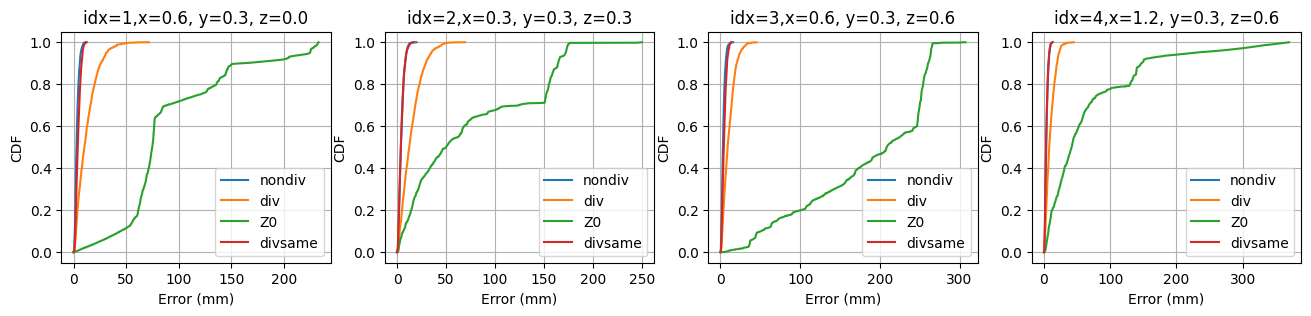

In [48]:
xs = np.array([0.6, 0.3, 0.6, 1.2])
ys = np.array([0.3, 0.3, 0.3, 0.3])
zs = np.array([0, 0.3, 0.6, 0.6])
trajectory = load_trajectories(filename="./data/real_trajectory_1.mat")
start_position = trajectory[0]

n_test = xs.shape[0]
n_samples = trajectory.shape[0]
test_times = 10

div_errors = np.zeros((test_times, n_test, n_samples))
nondiv_errors = np.zeros((test_times, n_test, n_samples))
z0_errors = np.zeros((test_times, n_test, n_samples))
divsame_errors = np.zeros((test_times, n_test, n_samples))
for i in range(test_times):
    div_traj, div_errors[i], div_centers = sim_z_diversity_array(trajectory, 'diverse', xs, ys, zs)
    nondiv_traj, nondiv_errors[i], nondiv_centers = sim_z_diversity_array(trajectory, 'non_diverse', xs, ys, zs)
    z0_traj, z0_errors[i], z0_centers = sim_z_diversity_array(trajectory, 'Z0', xs, ys, zs)
    divsame_traj, divsame_errors[i], divsame_centers = sim_z_diversity_array(trajectory, 'diverse_sameconvex', xs, ys, zs)
sio.savemat("./result_4positions.mat", 
            {
                "div_traj": div_traj,
                "div_errors": div_errors,
                "div_centers": div_centers,
                "nondiv_traj": nondiv_traj,
                "nondiv_errors": nondiv_errors,
                "nondiv_centers": nondiv_centers,
                "z0_traj": z0_traj,
                "z0_nondiv_errors": z0_errors,
                "z0_nondiv_centers": z0_centers,
                "divsame_traj": divsame_traj,
                "divsame_errors": divsame_errors,
                "divsame_centers": divsame_centers,

                "div_rx_positions": antenna_positions_pool["diverse"],
                "nondiv_rx_positions": antenna_positions_pool["non_diverse"],
                "z0_rx_positions": antenna_positions_pool["Z0"],
                "divsame_rx_positions": antenna_positions_pool["diverse_sameconvex"],
            })

n_cols = 4
n_rows = (n_test-1) // n_cols + 1
print(n_rows, n_cols)
plt.figure(1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
print(axs.shape)
iT = 0

for i in range(n_test):
    irow, icol = i // n_cols, i % n_cols
    plot_ax = axs[irow][icol] if len(axs.shape) > 1 else axs[icol]
    plot_utils.cdfplot(plot_ax, [nondiv_errors[0,i], div_errors[0,i], z0_errors[0,i], divsame_errors[0,i]], 
                       xlabel="Error (mm)", legends=["nondiv", "div","Z0", "divsame"])
    iT += 1
    x, y, z = div_centers[i][0], div_centers[i][1], div_centers[i][2]
    plot_ax.set_title(f"idx={iT},x={int(x*100) / 100}, y={int(y*100) / 100}, z={z}")